In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import xarray as xr
import glob
import datetime as dt
import tqdm
from matplotlib.patches import Rectangle
import pytz
from matplotlib.lines import Line2D
from cartopy import geodesic
import shapely
from matplotlib.patches import ConnectionPatch
from scipy.stats import kstest
from scipy.stats.mstats import mquantiles
import scipy.stats

In [2]:
def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-")    

def add_lt(df,tz):
    df["lt"] = df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone(tz))
    return df

def load_scws(rid,tz):
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,2:1,1:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    
    df1 = add_lt(df1,tz)    
        
    df1["year"] = df1.index.year
    df1["month"] = df1.index.month
    df1["hour"] = df1["lt"].dt.hour
    
    df1["rid"] = rid
    
    return df1

def remove_suspect_gusts(df):
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]


def assign_storm_class(data):
    data["aspect_ratio"] = data.major_axis_length / data.minor_axis_length     
    #Linear
    data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
    #Non-linear
    data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
    #Cellular
    data.loc[(data.local_max == 1),"class2"] = "Cellular"
    #Cluster of cells
    data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
    #Supercell
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
    #Linear hybrid
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"
    
    return data

In [3]:
tzs = {"68":'Australia/Melbourne',
       "64":'Australia/Adelaide',
       "8":'Australia/Brisbane',
       "72":'Australia/Queensland',
       "75":'Australia/Queensland',
       "19":'Australia/Queensland',
       "73":'Australia/Queensland',
       "78":'Australia/Queensland',
       "77":'Australia/Darwin',
       "49":'Australia/Victoria',
       "4":'Australia/Sydney',
       "40":'Australia/Canberra',
       "48":'Australia/West',
       "2":'Australia/Melbourne',
       "66":'Australia/Brisbane',
       "69":'Australia/NSW',
       "70":'Australia/Perth',
       "71":'Australia/Sydney',
      "63":'Australia/Darwin',
      "76":'Australia/Hobart',
      "77":"Australia/Darwin"}
       
rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
scws = [load_scws(rid,tzs[rid]) for rid in rids]
df_scw = remove_suspect_gusts(pd.concat(scws,axis=0))
print(str(df_scw.shape[0]) + " EVENTS")

418 EVENTS


In [47]:
def get_p_e(df_scw, c):

    if c == "all":
        df_sorted = df_scw.sort_values("gust",ascending=True)
        df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)
    else:
        df_sorted = df_scw[df_scw.cluster_new==c].sort_values("gust",ascending=True)
        df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)    
        
    p_e = df_sorted["rank"] / (df_sorted.shape[0] + 1)
    gust = df_sorted["gust"]    
    
    return p_e, gust

def fit_p_e(model,gust):
    
    try:
        loc,scale = model.fit(gust)
        #print(scipy.stats.kstest(gust.values,model.cdf,args=(loc,scale)))
        X=np.linspace(1/(gust.shape[0]+1),1,1000)
        p_e_fit = model.isf(X, loc=loc, scale=scale)
    except:
        shape,loc,scale = model.fit(gust)
        #print(scipy.stats.kstest(gust.values,model.cdf,args=(shape,loc,scale)))        
        X=np.linspace(1/(gust.shape[0]+1),1,1000)
        p_e_fit = model.isf(X, shape,loc=loc, scale=scale)    
        
    
        
    return p_e_fit, X
        
        
        

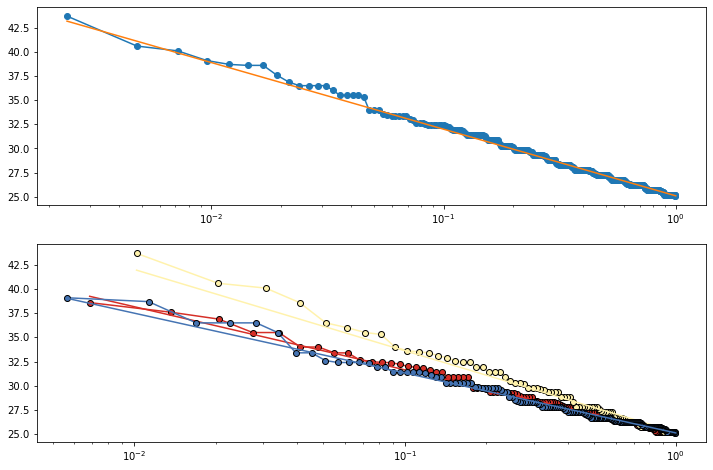

In [72]:
#Expon distribution (empirical probability)

plt.figure(figsize=[12,8])
p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

plt.subplot(2,1,1)

p_e, gust = get_p_e(df_scw, "all")
plt.plot(1-p_e,gust,marker="o")
p_e_fit, X = fit_p_e(scipy.stats.expon,gust)
plt.plot(X,p_e_fit)
plt.xscale("log")

plt.subplot(2,1,2)

for c in [0,1,2]:
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(1-p_e,gust,marker="o",color=p[c],mec="k")
    p_e_fit, X = fit_p_e(scipy.stats.expon,gust)
    plt.plot(X,p_e_fit,color=p[c])
    plt.xscale("log")

/jobfs/62940558.gadi-pbs/ipykernel_575858/3064519940.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3064519940.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3064519940.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/jobfs/62940558.gadi-pbs/ipykernel_575858/3064519940.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3064519940.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipy

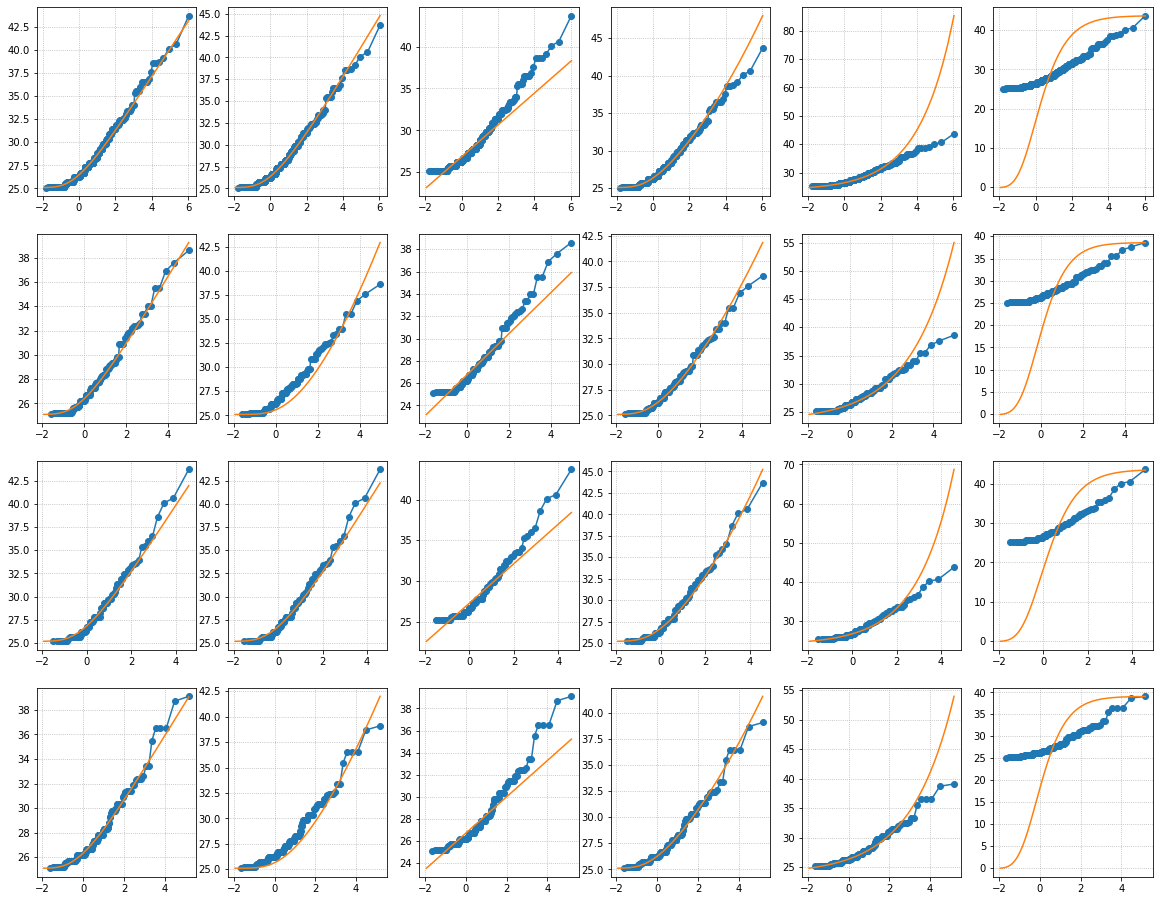

In [73]:
plt.figure(figsize=[20,16])
cnt=1

for c in ["all",0,1,2]:        
    for model in [scipy.stats.expon,scipy.stats.weibull_min,scipy.stats.gumbel_r,scipy.stats.pareto,scipy.stats.genextreme,scipy.stats.genpareto]:    
        plt.subplot(4,6,cnt)

        p_e, gust = get_p_e(df_scw, c)
        plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

        p_e_fit,X = fit_p_e(model, gust) 
        plt.plot(-np.log(-np.log(1-X)),p_e_fit)    

        #plt.title(title)
        plt.gca().grid(ls=":")

    #    plt.suptitle("Exponential fit")

        cnt=cnt+1

KstestResult(statistic=0.07481035563610638, pvalue=0.01761700622715079)
KstestResult(statistic=0.12401524600076966, pvalue=0.02110013072173961)
KstestResult(statistic=0.1298676414007249, pvalue=0.06921360763147669)
KstestResult(statistic=0.07552094847651555, pvalue=0.2548965383981351)


/jobfs/62940558.gadi-pbs/ipykernel_575858/3175154740.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3175154740.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3175154740.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3175154740.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


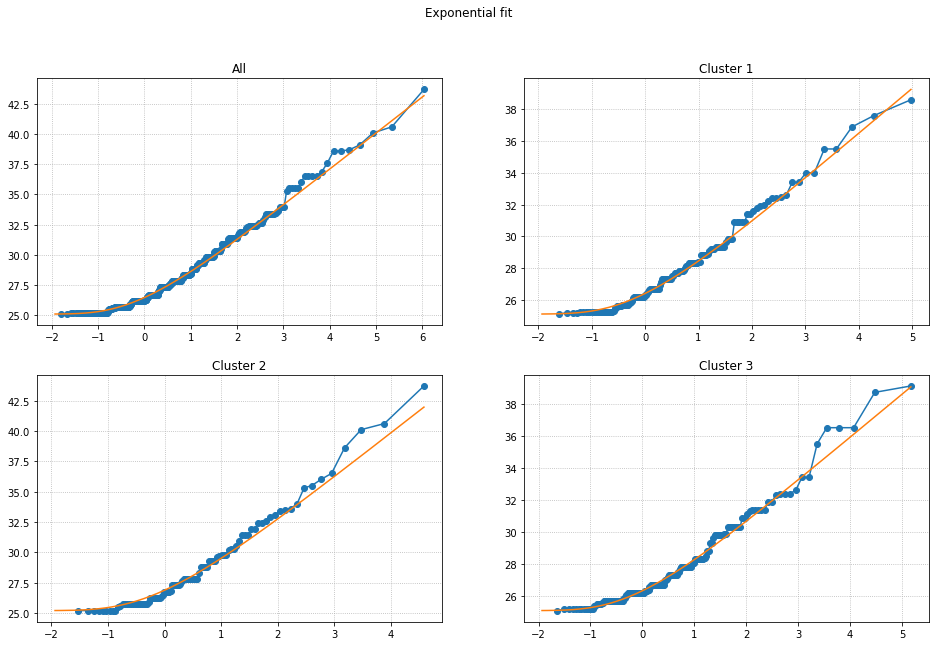

In [33]:
#Exponential distribition

plt.figure(figsize=[16,10])
cnt=1
for c,title in zip(["all",0,1,2],["All","Cluster 1","Cluster 2","Cluster 3"]):
    
    plt.subplot(2,2,cnt)
    
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

    p_e_fit,X = fit_p_e(scipy.stats.expon, gust) 
    plt.plot(-np.log(-np.log(1-X)),p_e_fit)    
    
    plt.title(title)
    plt.gca().grid(ls=":")
    
    plt.suptitle("Exponential fit")
    
    cnt=cnt+1

KstestResult(statistic=0.06650431485799393, pvalue=0.04733984831346649)
KstestResult(statistic=0.25825478549405234, pvalue=5.1166939817370875e-09)


/jobfs/62940558.gadi-pbs/ipykernel_575858/3610855932.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3610855932.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


KstestResult(statistic=0.11955162107217124, pvalue=0.11506913319742268)
KstestResult(statistic=0.265623418319752, pvalue=1.883061872503118e-11)


/jobfs/62940558.gadi-pbs/ipykernel_575858/3610855932.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/3610855932.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


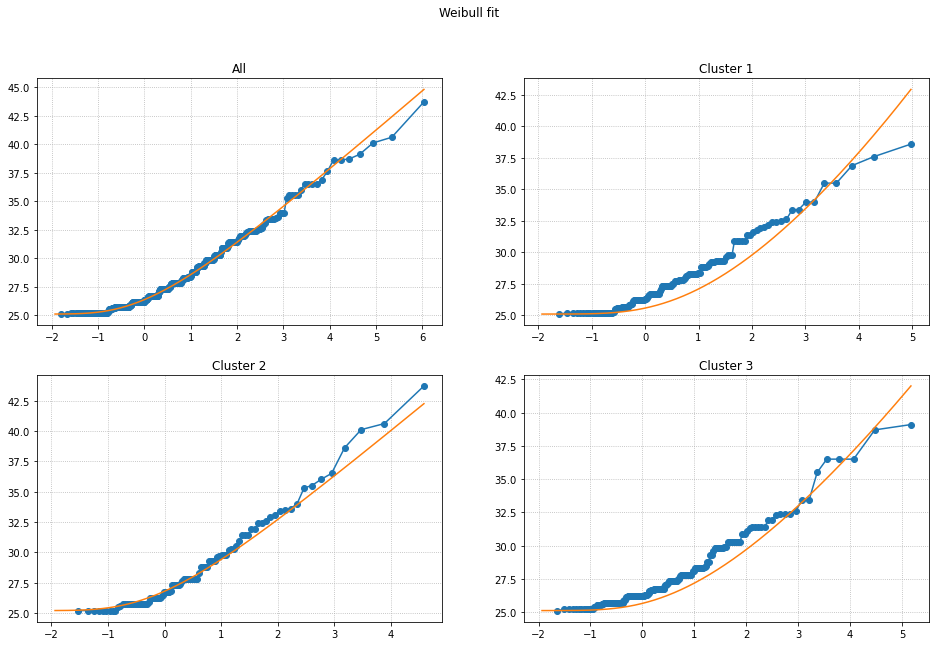

In [34]:
#Weibull distribition

plt.figure(figsize=[16,10])
cnt=1
for c,title in zip(["all",0,1,2],["All","Cluster 1","Cluster 2","Cluster 3"]):
    
    plt.subplot(2,2,cnt)
    
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

    p_e_fit,X = fit_p_e(scipy.stats.weibull_min, gust) 
    plt.plot(-np.log(-np.log(1-X)),p_e_fit)    
    
    plt.title(title)
    plt.gca().grid(ls=":")
    
    plt.suptitle("Weibull fit")
    
    cnt=cnt+1

KstestResult(statistic=0.13138146520788507, pvalue=9.438625247217262e-07)
KstestResult(statistic=0.10700504758430174, pvalue=0.06704971135271776)
KstestResult(statistic=0.12855447517176233, pvalue=0.07401391293753863)
KstestResult(statistic=0.15174386301080128, pvalue=0.0005284675293878877)


/jobfs/62940558.gadi-pbs/ipykernel_575858/2989660299.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/2989660299.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/2989660299.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/2989660299.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


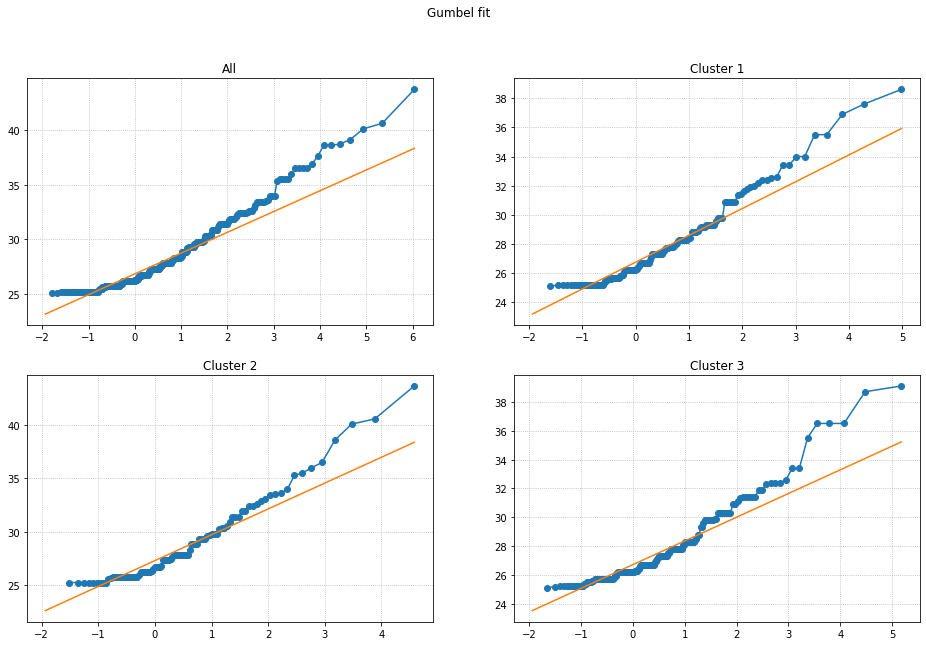

In [35]:
#Gumbel distribition

plt.figure(figsize=[16,10])
cnt=1
for c,title in zip(["all",0,1,2],["All","Cluster 1","Cluster 2","Cluster 3"]):
    
    plt.subplot(2,2,cnt)
    
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

    p_e_fit,X = fit_p_e(scipy.stats.gumbel_r, gust) 
    plt.plot(-np.log(-np.log(1-X)),p_e_fit)    
    
    plt.title(title)
    plt.gca().grid(ls=":")
    
    plt.suptitle("Gumbel fit")
    
    cnt=cnt+1

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/jobfs/62940558.gadi-pbs/ipykernel_575858/2273625108.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/jobfs/62940558.gadi-pbs/ipykernel_575858/2273625108.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


KstestResult(statistic=0.07132222138450156, pvalue=0.027061818192188558)
KstestResult(statistic=0.12060135366322314, pvalue=0.026978308799797568)
KstestResult(statistic=0.11512279457495544, pvalue=0.14128494807279152)


/jobfs/62940558.gadi-pbs/ipykernel_575858/2273625108.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/jobfs/62940558.gadi-pbs/ipykernel_575858/2273625108.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


KstestResult(statistic=0.09030325394620581, pvalue=0.10652857867897858)


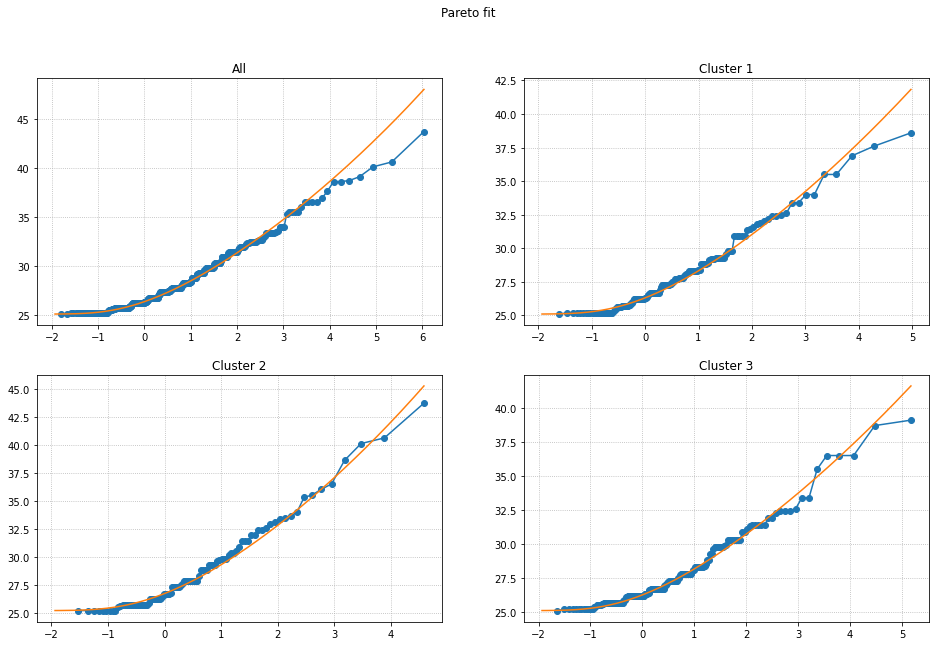

In [36]:
#Pareto distribition

plt.figure(figsize=[16,10])
cnt=1
for c,title in zip(["all",0,1,2],["All","Cluster 1","Cluster 2","Cluster 3"]):
    
    plt.subplot(2,2,cnt)
    
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

    p_e_fit,X = fit_p_e(scipy.stats.pareto, gust) 
    plt.plot(-np.log(-np.log(1-X)),p_e_fit)    
    
    plt.title(title)
    plt.gca().grid(ls=":")
    
    plt.suptitle("Pareto fit")
    
    cnt=cnt+1

KstestResult(statistic=0.5549876863004792, pvalue=1.2349671078402913e-121)
KstestResult(statistic=0.5284128841321316, pvalue=2.77214910049457e-38)


/jobfs/62940558.gadi-pbs/ipykernel_575858/1374031145.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/1374031145.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


KstestResult(statistic=0.5134684688430984, pvalue=2.878452795213947e-24)
KstestResult(statistic=0.5313998216612429, pvalue=6.422740607985854e-47)


/jobfs/62940558.gadi-pbs/ipykernel_575858/1374031145.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/1374031145.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


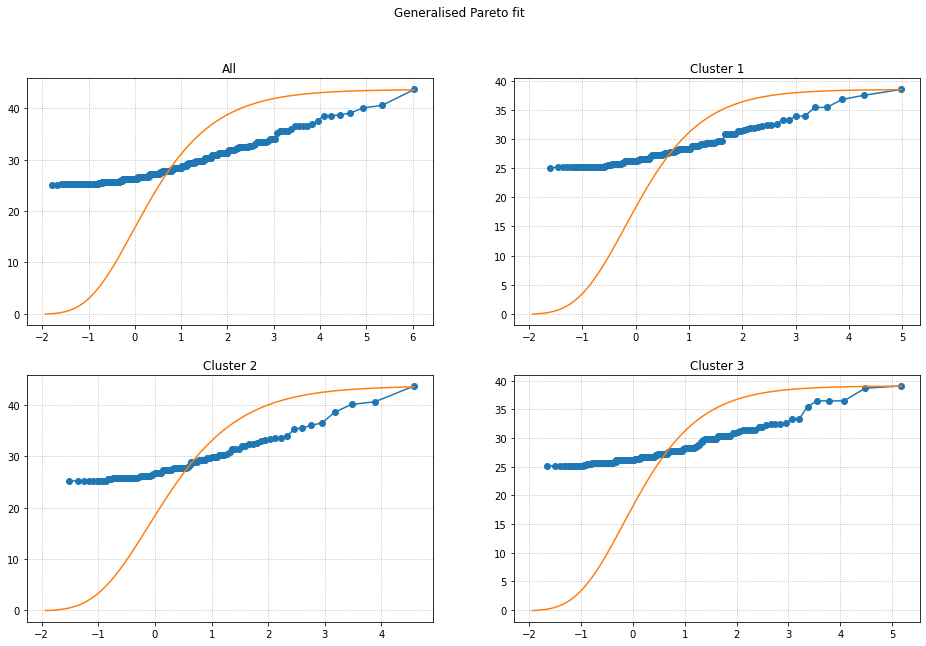

In [37]:
#Generalised Pareto distribition

plt.figure(figsize=[16,10])
cnt=1
for c,title in zip(["all",0,1,2],["All","Cluster 1","Cluster 2","Cluster 3"]):
    
    plt.subplot(2,2,cnt)
    
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

    p_e_fit,X = fit_p_e(scipy.stats.genpareto, gust) 
    plt.plot(-np.log(-np.log(1-X)),p_e_fit)    
    
    plt.title(title)
    plt.gca().grid(ls=":")
    
    plt.suptitle("Generalised Pareto fit")
    
    cnt=cnt+1

KstestResult(statistic=0.08005665944398038, pvalue=0.008887608350495844)
KstestResult(statistic=0.09961288953986014, pvalue=0.1050745259471142)
KstestResult(statistic=0.11337094126464314, pvalue=0.1529026429878672)


/jobfs/62940558.gadi-pbs/ipykernel_575858/2761024321.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/2761024321.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)
/jobfs/62940558.gadi-pbs/ipykernel_575858/2761024321.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


KstestResult(statistic=0.07660494869185289, pvalue=0.24040868430339934)


/jobfs/62940558.gadi-pbs/ipykernel_575858/2761024321.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(-np.log(1-X)),p_e_fit)


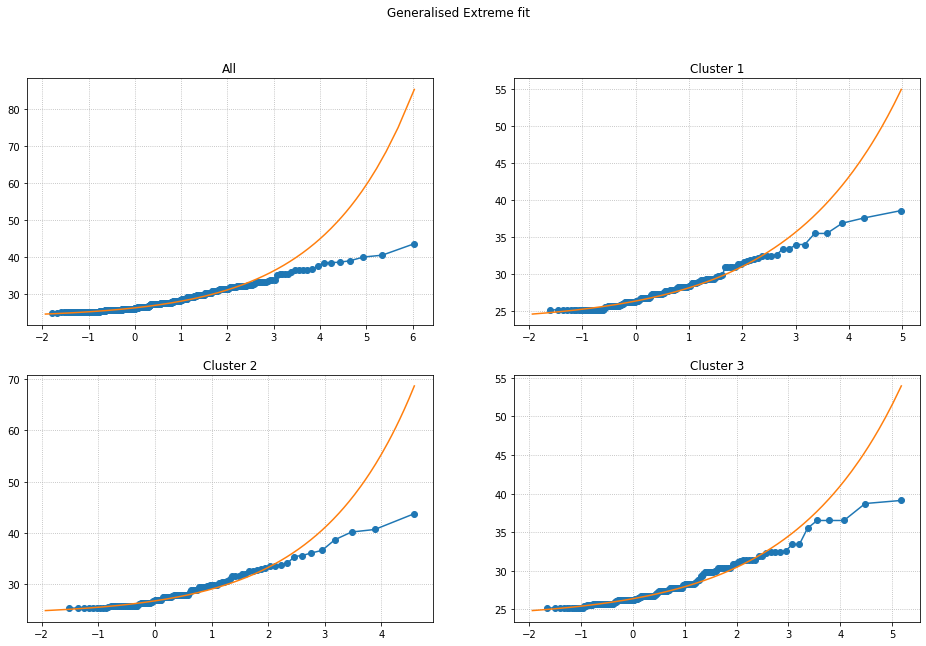

In [38]:
#Generalised Extreme distribition

plt.figure(figsize=[16,10])
cnt=1
for c,title in zip(["all",0,1,2],["All","Cluster 1","Cluster 2","Cluster 3"]):
    
    plt.subplot(2,2,cnt)
    
    p_e, gust = get_p_e(df_scw, c)
    plt.plot(-np.log(-np.log(p_e)),gust,marker="o")

    p_e_fit,X = fit_p_e(scipy.stats.genextreme, gust) 
    plt.plot(-np.log(-np.log(1-X)),p_e_fit)    
    
    plt.title(title)
    plt.gca().grid(ls=":")
    
    plt.suptitle("Generalised Extreme fit")
    
    cnt=cnt+1

In [53]:
p_e, gust = get_p_e(df_scw, "all")

model=scipy.stats.genpareto
params = model.fit(gust)
#X=np.linspace(1/(gust.shape[0]+1),1,1000)
#p_e_fit = model.isf(X, loc=loc, scale=scale)
scipy.stats.kstest(gust, model.cdf, args=params)

KstestResult(statistic=0.5549876863004792, pvalue=1.2349671078402913e-121)

In [54]:
params

(-1.0588877473196847, -0.13767323266756898, 46.419175057075805)